In [1]:
import pandas as pd
from plot_triad import plot_triad_eop
from eop_post_cf import anomalies_from_pred, AnomalyConfig, WeightConfig, compute_eop

In [2]:
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]

In [3]:
# ---- 1) Paths (EDIT THESE) ----
pred_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF.csv"   
flows_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv" 
train_end = "2021-12-01"     # training window end used by CF++

# ---- 2) Load ----
pred = pd.read_csv(pred_path)
flows = pd.read_csv(flows_path)
pred

,orig,dest,month,flow,mu_hat,excess_pct
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912
...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335


In [4]:
# ---- 3) Anomalies (Z or percent excess) ----
anom_cfg = AnomalyConfig(train_end=train_end, eps=1.0, use_standardized=True)  # Z by default
pred_anom = anomalies_from_pred(pred, anom_cfg)
print("Estimated phi_hat:", pred_anom.attrs.get('phi_hat'))
pred_anom

Estimated phi_hat: 158.5048897277346


,orig,dest,month,flow,mu_hat,excess_pct,z_std
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653,4.047579
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094,3.298161
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572,1.712868
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659,0.865919
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912,0.859851
...,...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277,-0.760998
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331,-0.742660
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358,-0.775379
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335,-0.590769


In [5]:
# ---- 4) Triads & windows ----
triads = [
    ("VE","CL","US"),
    ("VE","PE","US"),
    ("VE","EC","US"),
    ("VE","CO","US"),
    ("CO","VE","US"),

    
    # add more, e.g. ("HTI","DOM","USA"), ("SYR","TUR","DEU")
]

In [24]:
windows = [
    # # Basic windows (no gating), with 3-month smoothing for w
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode=None,
                 label="m12_24|ma3", train_end=train_end),

    # WeightConfig(window="m6_18",  smooth_ma=3, gate_mode=None,
    #              label="m6_18|ma3", train_end=train_end),

    # WeightConfig(window="upto_12",smooth_ma=3, gate_mode=None,
    #              label="upto_12|ma3", train_end=train_end),

#     # Optional gating: only count w when the window-mean share is "unusually high"
    # WeightConfig(window="m12_24", smooth_ma=3, gate_mode="zscore", z_thresh=1.0,
    #              label="m12_24|z≥1.0|ma3", train_end=train_end),

#     # Or percentile-based gate (top 10% of baseline months)
#     WeightConfig(window="m12_24", smooth_ma=3, gate_mode="percentile", perc_thresh=0.90,
#                  label="m12_24|p90|ma3", train_end=train_end),
]

In [28]:
# ---- 5) Compute EOP ----
# eop = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std")  # or 'excess_pct'
eop = compute_eop(pred_anom, flows, triads, windows) 

# eop.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/0915_eop_results.csv", index=False)
# print("Saved: eop_results.csv")

# eop = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/0915_eop_results.csv")
eop

,i,j,k,label,window,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP
192,CO,VE,US,m12_24|ma3,m12_24,2019-01-01,4133.0,5039.426173,-1.014193,0.000000,-0.000000
193,CO,VE,US,m12_24|ma3,m12_24,2019-02-01,4594.0,5747.935158,-1.208938,0.000000,-0.000000
194,CO,VE,US,m12_24|ma3,m12_24,2019-03-01,5294.0,6346.907462,-1.049755,0.000000,-0.000000
195,CO,VE,US,m12_24|ma3,m12_24,2019-04-01,4736.0,5881.369404,-1.186274,0.000000,-0.000000
196,CO,VE,US,m12_24|ma3,m12_24,2019-05-01,4763.0,5875.381892,-1.152695,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
91,VE,PE,US,m12_24|ma3,m12_24,2022-08-01,11343.0,2350.569315,14.732255,0.353235,5.203946
92,VE,PE,US,m12_24|ma3,m12_24,2022-09-01,13345.0,2294.301863,18.324963,0.362408,6.641108
93,VE,PE,US,m12_24|ma3,m12_24,2022-10-01,16403.0,2832.856701,20.251202,0.371182,7.516879
94,VE,PE,US,m12_24|ma3,m12_24,2022-11-01,9258.0,2253.670820,11.719254,0.383694,4.496607


In [29]:
# ---- 6) Quick summaries ----
# Peak month per triad & window
peaks = (eop.sort_values(['i','j','k','window','EOP'], ascending=[True,True,True,True,False])
           .groupby(['i','j','k','window', 'label'])
           .head(10)[['i','j','k','window','label','month','EOP']])
print("Peaks:")
peaks

Peaks:


,i,j,k,window,label,month,EOP
229,CO,VE,US,m12_24,m12_24|ma3,2022-02-01,6.702635
228,CO,VE,US,m12_24,m12_24|ma3,2022-01-01,5.908749
230,CO,VE,US,m12_24,m12_24|ma3,2022-03-01,3.799198
227,CO,VE,US,m12_24,m12_24|ma3,2021-12-01,3.032725
223,CO,VE,US,m12_24,m12_24|ma3,2021-08-01,2.557633
226,CO,VE,US,m12_24,m12_24|ma3,2021-11-01,2.374491
225,CO,VE,US,m12_24,m12_24|ma3,2021-10-01,2.347502
224,CO,VE,US,m12_24,m12_24|ma3,2021-09-01,2.318924
222,CO,VE,US,m12_24,m12_24|ma3,2021-07-01,2.006408
238,CO,VE,US,m12_24,m12_24|ma3,2022-11-01,1.646870


In [30]:
# 这代码不对 还没改window and label

# 2022 annual means
eop['year'] = pd.to_datetime(eop['month']).dt.year
ann_2022 = (eop[eop['year']==2022]
            .groupby(['i','j','k','window','label'])['EOP']
            .mean()
            .reset_index()
            .sort_values(['i','j','k','window','label']))
print("2022 means:")
ann_2022

2022 means:


,i,j,k,window,label,EOP
0,CO,VE,US,m12_24,m12_24|ma3,1.858012
1,VE,CL,US,m12_24,m12_24|ma3,0.511587
2,VE,CO,US,m12_24,m12_24|ma3,8.474905
3,VE,EC,US,m12_24,m12_24|ma3,0.603878
4,VE,PE,US,m12_24,m12_24|ma3,3.833273


In [31]:
# eop124 = eop[eop['window'] == 'm12_24']
# eop124 = eop[(eop['i'] == 'VE') & (eop['j'] == 'PE') & (eop['k'] == 'US') & (eop['label'] == 'm12_24|ma3')]
eopPE = eop[(eop['i'] == 'VE') & (eop['j'] == 'PE') & (eop['k'] == 'US')]
eopPE

,i,j,k,label,window,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP,year
48,VE,PE,US,m12_24|ma3,m12_24,2019-01-01,1444.0,1921.991286,-0.866010,0.000000,-0.000000,2019
49,VE,PE,US,m12_24|ma3,m12_24,2019-02-01,1653.0,2192.210166,-0.914736,0.000000,-0.000000,2019
50,VE,PE,US,m12_24|ma3,m12_24,2019-03-01,2368.0,2420.652752,-0.085003,0.000000,-0.000000,2019
51,VE,PE,US,m12_24|ma3,m12_24,2019-04-01,1715.0,2243.100773,-0.885668,0.000000,-0.000000,2019
52,VE,PE,US,m12_24|ma3,m12_24,2019-05-01,1632.0,2240.817191,-1.021556,0.000000,-0.000000,2019
53,VE,PE,US,m12_24|ma3,m12_24,2019-06-01,1795.0,2326.945869,-0.875897,0.000000,-0.000000,2019
54,VE,PE,US,m12_24|ma3,m12_24,2019-07-01,1890.0,2246.368599,-0.597224,0.000000,-0.000000,2019
55,VE,PE,US,m12_24|ma3,m12_24,2019-08-01,2029.0,2308.628442,-0.462256,0.000000,-0.000000,2019
56,VE,PE,US,m12_24|ma3,m12_24,2019-09-01,1544.0,1879.408167,-0.614528,0.000000,-0.000000,2019
57,VE,PE,US,m12_24|ma3,m12_24,2019-10-01,1490.0,1929.669634,-0.794994,0.000000,-0.000000,2019


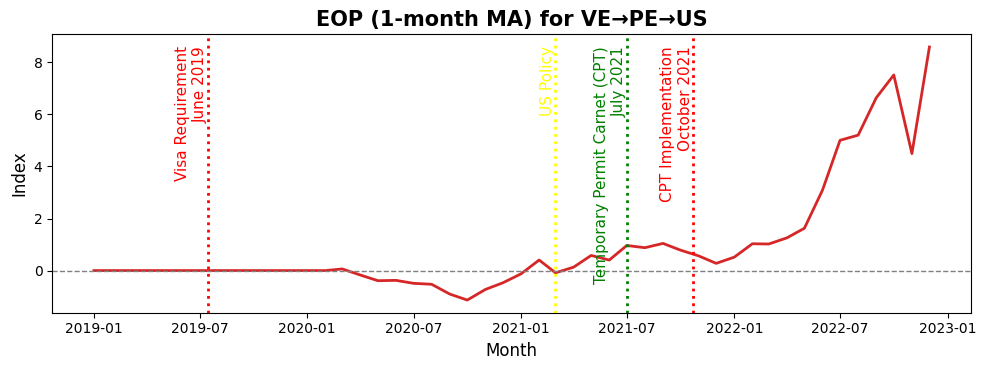

In [32]:
plot_triad_eop(
    eopPE,
    i="VE", j="PE", k="US",
    ma=1,
    policies=policies_PE,
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

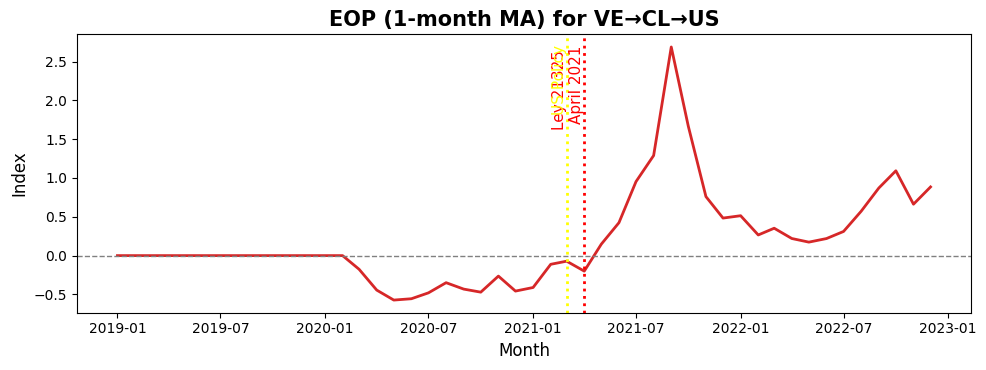

In [33]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CL') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CL", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

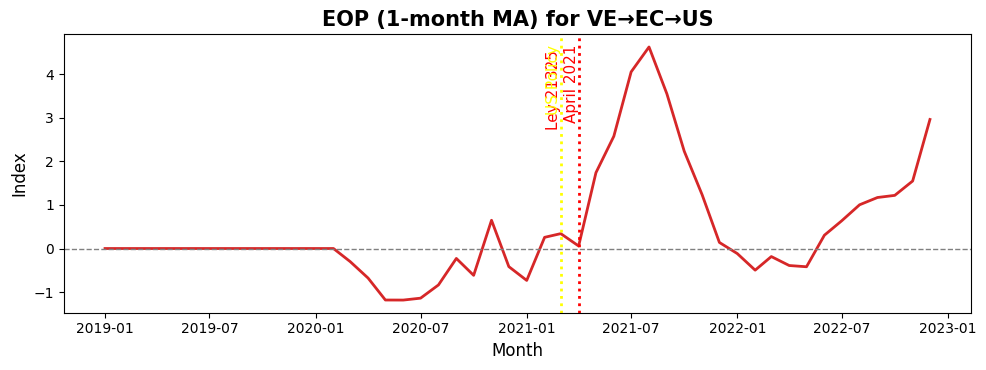

In [34]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'EC') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="EC", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

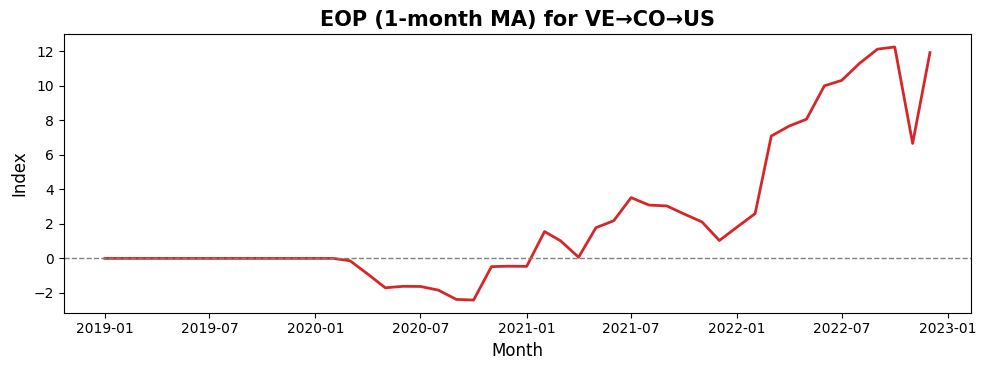

In [35]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CO') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CO", k="US",
    ma=1,
    # policies=policies_CO,
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

In [ ]:
# Usage example for eop_post_cf.py
# Inputs:
#   pred_path  -> your saved CF++ predictions with columns: orig, dest, month, flow, mu_hat
#   flows_path -> observed flows (same schema as in pred; used only for computing weights w)

import pandas as pd
from eop_post_cf import anomalies_from_pred, AnomalyConfig, WeightConfig, compute_eop

# ---- 1) Paths (EDIT THESE) ----
pred_path = "pred.csv"       # <-- replace with your file
flows_path = "flows.csv"     # <-- replace with your file
train_end = "2021-12-01"     # training window end used by CF++

# ---- 2) Load ----
pred = pd.read_csv(pred_path)
flows = pd.read_csv(flows_path)

# ---- 3) Anomalies (Z or percent excess) ----
anom_cfg = AnomalyConfig(train_end=train_end, eps=1.0, use_standardized=True)  # Z by default
pred_anom = anomalies_from_pred(pred, anom_cfg)
print("Estimated phi_hat:", pred_anom.attrs.get('phi_hat'))

# ---- 4) Triads & windows ----
triads = [
    ("VEN","CHL","USA"),
    ("VEN","PER","USA"),
    ("VEN","ECU","USA"),
    # add more, e.g. ("HTI","DOM","USA"), ("SYR","TUR","DEU")
]

windows = [
    # Basic windows (no gating), with 3-month smoothing for w
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode=None, train_end=train_end),
    WeightConfig(window="m6_18",  smooth_ma=3, gate_mode=None, train_end=train_end),
    WeightConfig(window="upto_12",smooth_ma=3, gate_mode=None, train_end=train_end),

    # Optional gating: only count w when the window-mean share is "unusually high"
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode="zscore", z_thresh=1.0, train_end=train_end),
    # Or percentile-based gate (top 10% of baseline months)
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode="percentile", perc_thresh=0.90, train_end=train_end),
]

# ---- 5) Compute EOP ----
eop = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std")  # or 'excess_pct'
eop.to_csv("eop_results.csv", index=False)
print("Saved: eop_results.csv")

# ---- 6) Quick summaries ----
# Peak month per triad & window
peaks = (eop.sort_values(['i','j','k','window','EOP'], ascending=[True,True,True,True,False])
           .groupby(['i','j','k','window'])
           .head(1)[['i','j','k','window','month','EOP']])
print("Peaks:")
print(peaks)

# 2022 annual means
eop['year'] = pd.to_datetime(eop['month']).dt.year
ann_2022 = (eop[eop['year']==2022]
            .groupby(['i','j','k','window'])['EOP']
            .mean()
            .reset_index()
            .sort_values(['i','j','k','window']))
print("2022 means:")
print(ann_2022)